# 03_session_id_with_created_at

## Assumption:
1. Sort the records in each event_id group in ascending order by created_at. If the time difference between two adjacent records exceeds a certain threshold (such as 1 hour), it is considered a new session.
2. Based on experience, we determine that the threshold is 45 minutes. In addition, we will check the data distribution and select another reasonable threshold. The two are compared and the one with the best performance is selected.
## Result:
 45 minutes as a threshold is more suitable for analyzing the effect of the course/entire event. We also evaluated the case of 788 seconds as a threshold, which is suitable for exploring the behavior patterns of users with high-frequency interactions in a short period of time. Finally, 45 minutes was chosen as the threshold for more robustness.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import weibull_min, kstest

In [2]:
df = pd.read_csv("/Users/olivey/Downloads/sample.csv")
df = df[~df['created_at'].isna()].copy()
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df = df.sort_values(by=['event_id', 'created_at'])

Timestamp statistics for each event_id:
count    3766.000000
mean        1.328200
std         1.922146
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        26.000000
Name: created_at, dtype: float64


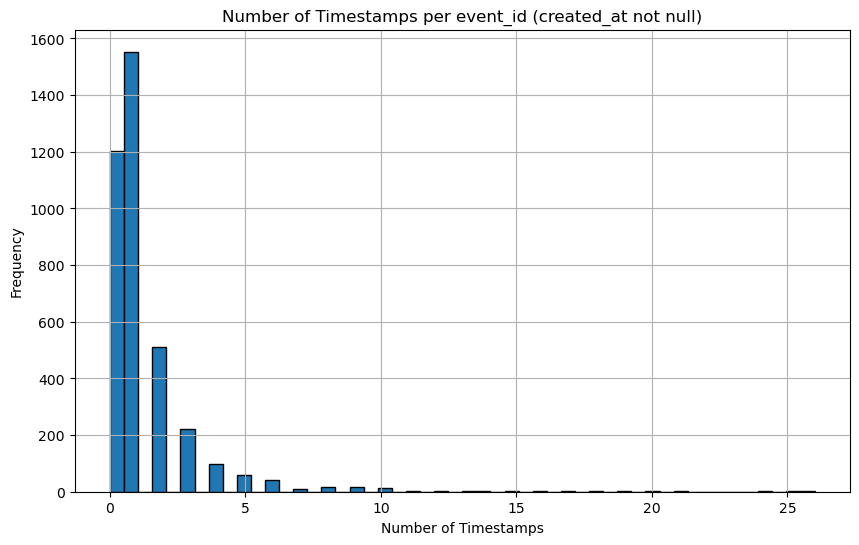

In [4]:
event_timestamp_counts = df.groupby('event_id')['created_at'].count()

print("Timestamp statistics for each event_id:")
print(event_timestamp_counts.describe())

plt.figure(figsize=(10, 6))
plt.hist(event_timestamp_counts, bins=50, edgecolor='black')
plt.title("Number of Timestamps per event_id (created_at not null)")
plt.xlabel("Number of Timestamps")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [5]:
# filter out event_id with only one timestamp：avoid affecting session partition logic
event_counts = df.groupby('event_id')['created_at'].count()
valid_event_ids = event_counts[event_counts > 1].index
df_multi = df[df['event_id'].isin(valid_event_ids)].copy()

Description of the time difference of multiple timestamp event_id:
count    6.029000e+03
mean     8.695261e+04
std      4.772598e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.380000e+02
max      1.106719e+07
Name: time_diff_seconds, dtype: float64


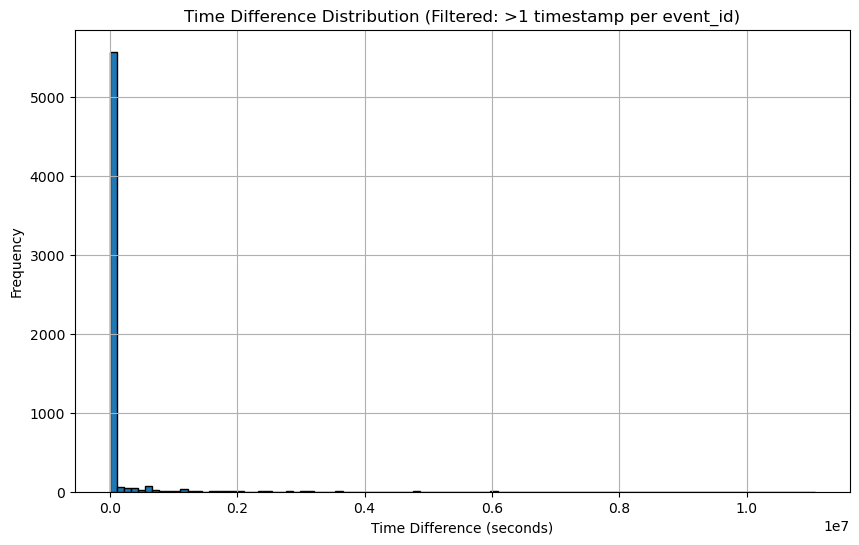

In [6]:
df_multi = df_multi.sort_values(by=['event_id', 'created_at'])
df_multi['time_diff'] = df_multi.groupby('event_id')['created_at'].diff().fillna(pd.Timedelta(seconds=0))
df_multi['time_diff_seconds'] = df_multi['time_diff'].dt.total_seconds()

print("Description of the time difference of multiple timestamp event_id:")
print(df_multi['time_diff_seconds'].describe())


plt.figure(figsize=(10, 6))
plt.hist(df_multi['time_diff_seconds'], bins=100, edgecolor='black')
plt.title("Time Difference Distribution (Filtered: >1 timestamp per event_id)")
plt.xlabel("Time Difference (seconds)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Threshold

### Finding:
 1. 25% quantiles: 2.38min
 2. 50% quantiles: 13.14min
 3. 75% quantiles: 295.91min = 4.93h
### Result:
    Considering the length of time it takes to answer questions in a typical class, we choose 50% percentile as the threshold.

95% quantiles: 1212219 秒
99% quantiles: 4150228 秒
Description of the time difference after cleaning:
count    2.380000e+03
mean     1.620961e+05
std      4.754494e+05
min      1.000000e+00
25%      1.430000e+02
50%      7.885000e+02
75%      1.775450e+04
max      3.980295e+06
Name: time_diff_seconds, dtype: float64


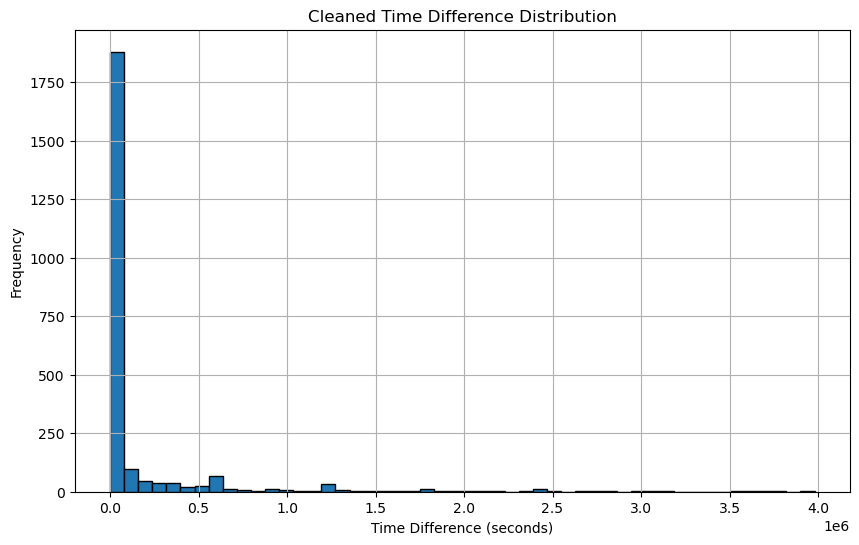

In [8]:
# only keep time differences > 0
filtered = df_multi[df_multi['time_diff_seconds'] > 0].copy()

# look at the 95% / 99% quantiles to decide whether to truncate the long tail
q95 = filtered['time_diff_seconds'].quantile(0.95)
q99 = filtered['time_diff_seconds'].quantile(0.99)
print(f"95% quantiles: {q95:.0f} 秒")
print(f"99% quantiles: {q99:.0f} 秒")

# remove extreme tails (eg > 99%)
filtered = filtered[filtered['time_diff_seconds'] < q99]

print("Description of the time difference after cleaning:")
print(filtered['time_diff_seconds'].describe())


plt.figure(figsize=(10, 6))
plt.hist(filtered['time_diff_seconds'], bins=50, edgecolor='black')
plt.title("Cleaned Time Difference Distribution")
plt.xlabel("Time Difference (seconds)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Compare with 45min & 788s(50% quantiles)

In [11]:
df1 = pd.read_csv("/Users/olivey/Downloads/sample.csv")
df1 = df1[~df1['created_at'].isna()].copy()
df1['created_at'] = pd.to_datetime(df1['created_at'], errors='coerce')

# only keep event_ids with at least two timestamps
event_counts = df1.groupby('event_id')['created_at'].count()
valid_event_ids = event_counts[event_counts > 1].index
df1 = df1[df1['event_id'].isin(valid_event_ids)].copy()
df1 = df1.sort_values(by=['event_id', 'created_at'])

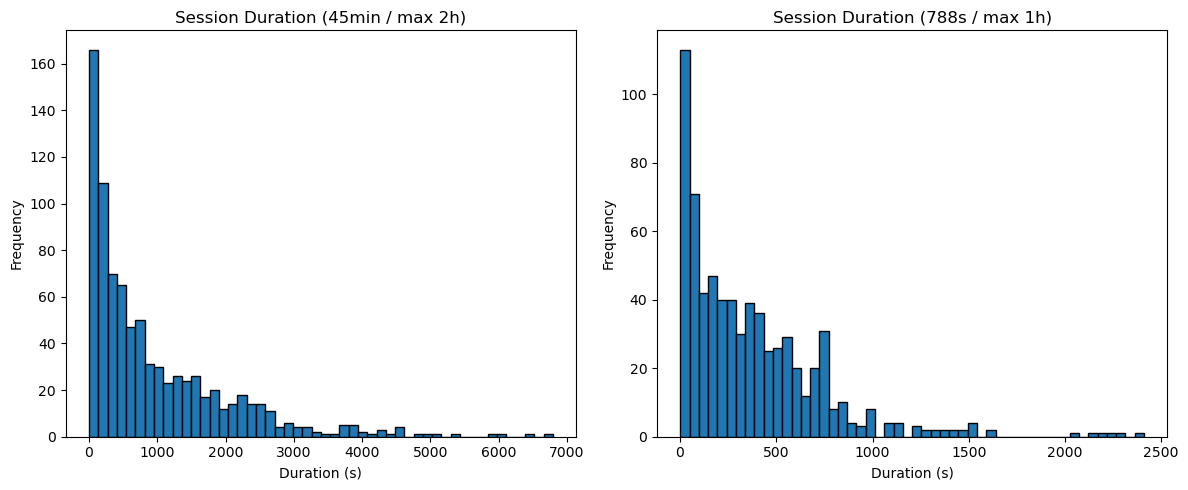

 45 minutes split session duration：
count     838.000000
mean      954.731504
std      1055.736192
min         1.000000
25%       185.000000
50%       569.500000
75%      1431.750000
max      6794.000000
Name: session_duration, dtype: float64
788S split session duration：
count     687.000000
mean      370.074236
std       363.868964
min         1.000000
25%        87.500000
50%       271.000000
75%       540.500000
max      2410.000000
Name: session_duration, dtype: float64


In [18]:
# session splitting function (consider gap + maximum duration)
def assign_sessions_with_gap_and_maxspan(df, max_gap_seconds=2700, max_session_span_seconds=7200):
    df = df.copy()
    df['session_id'] = 0
    last_event = None
    session_counter = 0
    session_start_time = None
    last_time = None

    for idx, row in df.iterrows():
        current_event = row['event_id']
        current_time = row['created_at']

        if current_event != last_event:
            session_counter = 0
            session_start_time = current_time
        else:
            gap = (current_time - last_time).total_seconds()
            span = (current_time - session_start_time).total_seconds()
            if gap > max_gap_seconds or span > max_session_span_seconds:
                session_counter += 1
                session_start_time = current_time

        df.at[idx, 'session_id'] = session_counter
        last_event = current_event
        last_time = current_time

    return df

# two types of parameter segmentation session
df_45min_smart = assign_sessions_with_gap_and_maxspan(df1, max_gap_seconds=2700, max_session_span_seconds=7200)
df_788s_smart = assign_sessions_with_gap_and_maxspan(df1, max_gap_seconds=788, max_session_span_seconds=3600)

# calculating session duration
def compute_session_durations(df):
    session_df = df.groupby(['event_id', 'session_id']).agg(
        session_start=('created_at', 'min'),
        session_end=('created_at', 'max'),
        count=('created_at', 'count')
    ).reset_index()
    session_df['session_duration'] = (session_df['session_end'] - session_df['session_start']).dt.total_seconds()
    #only keep valid sessions with duration > 0
    session_df = session_df[session_df['session_duration'] > 0].copy()
    return session_df

session_45min = compute_session_durations(df_45min_smart)
session_788s = compute_session_durations(df_788s_smart)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(session_45min['session_duration'], bins=50, edgecolor='black')
plt.title("Session Duration (45min / max 2h)")
plt.xlabel("Duration (s)")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(session_788s['session_duration'], bins=50, edgecolor='black')
plt.title("Session Duration (788s / max 1h)")
plt.xlabel("Duration (s)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


print(" 45 minutes split session duration：")
print(session_45min['session_duration'].describe())
print("788S split session duration：")
print(session_788s['session_duration'].describe())